In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from ctapipe_io_lst import LSTEventSource
from ctapipe.image.extractor import LocalPeakWindowSum
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from traitlets.config.loader import Config 
from lstchain.calib.camera.r0 import LSTR0Corrections

from lstchain.calib.camera.time_correction_calculate import TimeCorrectionCalculate 
from lstchain.calib.camera.pulse_time_correction import PulseTimeCorrection

plt.rcParams['font.size'] = 25

In [2]:
! rm time_calib_run1625.h5

# Create coefficients to time correction and save to h5py file using camera calibration data

In [3]:
%%time

reader = LSTEventSource(
    input_url="/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0000.fits.fz",
    max_events=20000)

charge_config = Config({
    "LocalPeakWindowSum":{
        "window_shift":4,
        "window_width":11
    }
})

# Here you have to give path, where you want save calibration file
timeCorr = TimeCorrectionCalculate(calib_file_path='time_calib_run1625.h5',
                                   config=charge_config, 
                                   subarray=reader.subarray)
tel_id = 1
config = Config({
        "LSTR0Corrections": {
            "pedestal_path": None, # if baseline correction was done in EVB
            "tel_id": tel_id,
            "r1_sample_start":3,
            "r1_sample_end":39
        }
})

lst_r0 = LSTR0Corrections(config=config)

for i, ev in enumerate(reader):
    if ev.index.event_id%5000 == 0:
        print(ev.index.event_id)
        
    lst_r0.calibrate(ev)                  # Cut in signal to avoid cosmic events      
    if ev.r0.tel[tel_id].trigger_type == 1 and np.mean(ev.r1.tel[tel_id].waveform[:, :, :]) > 100:
        timeCorr.calibrate_pulse_time(ev)

/home/pawel1/anaconda3/envs/lst-dev-ctapipe0.8/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


5000
10000
15000
20000
CPU times: user 9min 28s, sys: 13.8 s, total: 9min 41s
Wall time: 5min 56s


In [4]:
timeCorr.finalize()

# Apply time correction to camera calibration data

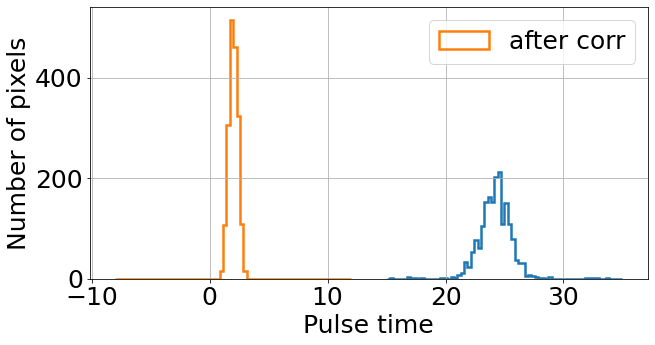

std before correction 1.40
std after correction 0.49


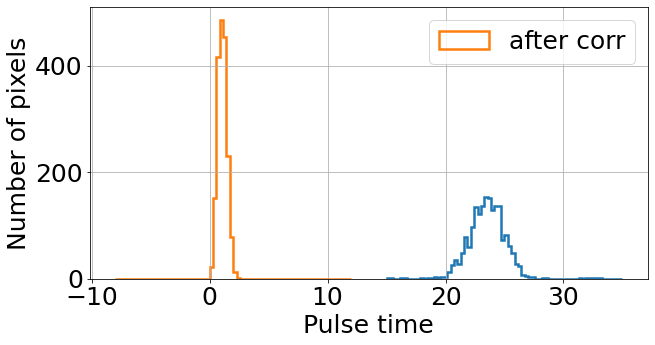

std before correction 1.58
std after correction 0.47


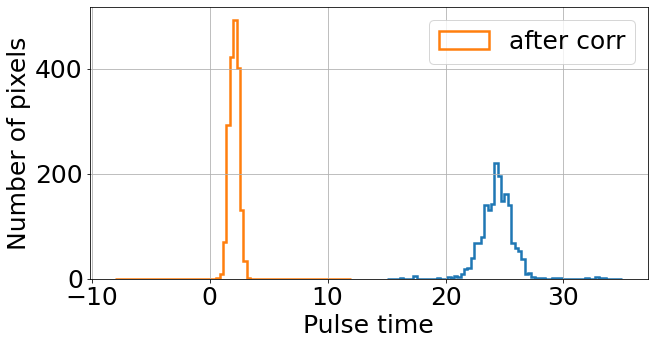

std before correction 1.39
std after correction 0.50


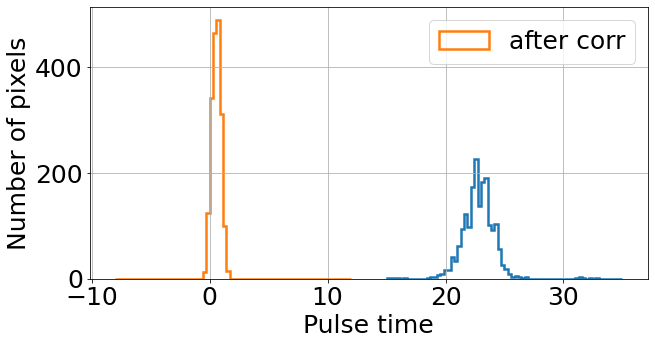

std before correction 1.41
std after correction 0.47


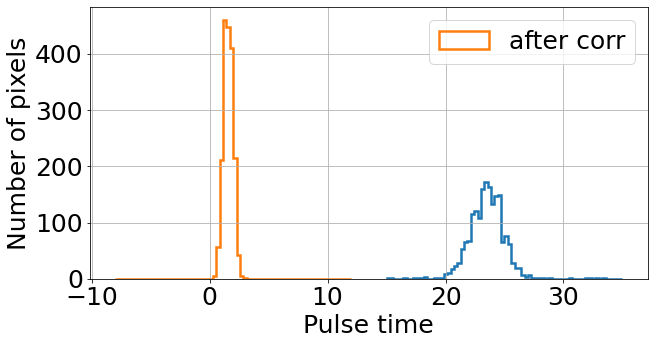

std before correction 1.52
std after correction 0.49


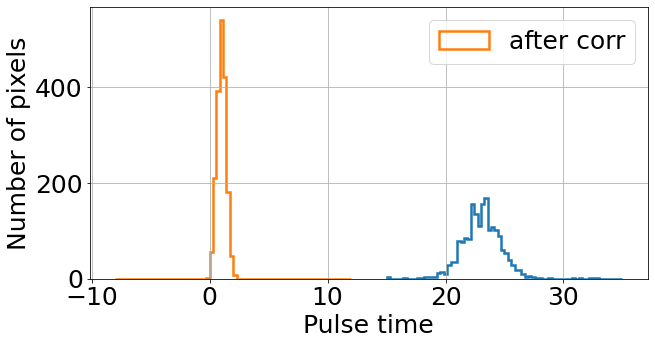

std before correction 1.71
std after correction 0.47


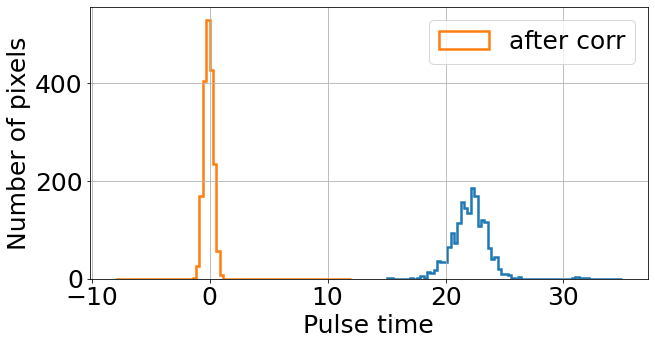

std before correction 1.55
std after correction 0.48


In [5]:
reader = LSTEventSource(
    input_url="/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0001.fits.fz",
    max_events=15)

pulse_corr = PulseTimeCorrection(calib_file_path='time_calib_run1625.h5')
tel_id = 1
config = Config({
        "LSTR0Corrections": {
            "pedestal_path": None, # if baseline correction was done in EVB
            "tel_id": tel_id,
            "r1_sample_start":3,
            "r1_sample_end":39
        }
})

lst_r0 = LSTR0Corrections(config=config)
extractor = LocalPeakWindowSum(window_width=11, window_shift=4, subarray=reader.subarray)
gain = 0

for i, ev in enumerate(reader):        
    lst_r0.calibrate(ev)                  # Cut in signal to avoid cosmic events    
    if ev.r0.tel[tel_id].trigger_type == 1 and np.mean(ev.r1.tel[tel_id].waveform[:, :, :]) > 100:
        no_gain_selection = np.zeros((2,1855), dtype=np.int8)
        charge, pulse = extractor(ev.r1.tel[tel_id].waveform[:, :, :], tel_id, no_gain_selection)
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse)
        time_fan = pulse_corr.fan_array[0, :, 0]/2 # mean time from correction curve
        pulse_corr_array = pulse_corr_array - time_fan
        
        plt.figure(figsize=(10, 5))
        plt.hist(pulse[gain,:], bins=70, range=(15, 35), 
                 histtype='step', lw=2.5)
        plt.hist(pulse_corr_array[gain,:], bins=70, range=(-8, 12), 
                 histtype='step', lw=2.5, label="after corr")
        plt.xlabel("Pulse time")
        plt.ylabel("Number of pixels")
        plt.legend()
        plt.grid(True)
        plt.show()
        print("std before correction {:.2f}".format(np.std(pulse)))
        print("std after correction {:.2f}".format(np.std(pulse_corr_array)))

# Apply time correction to cosmic events 

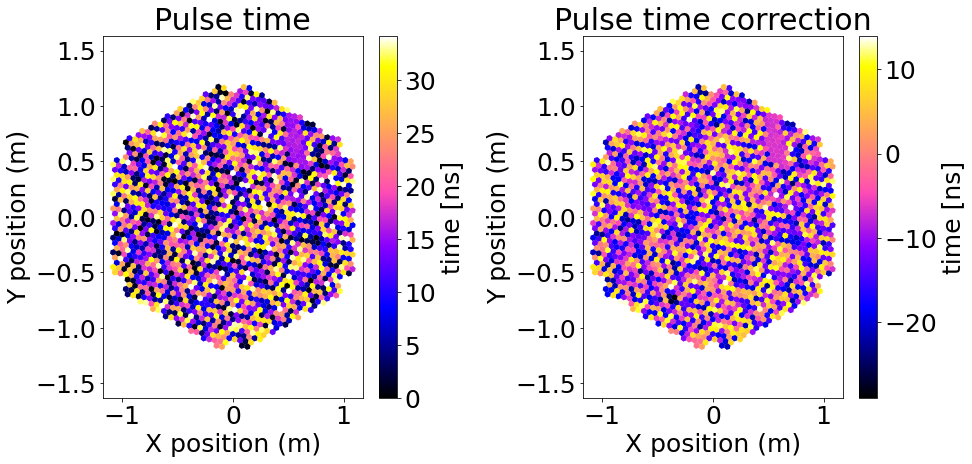

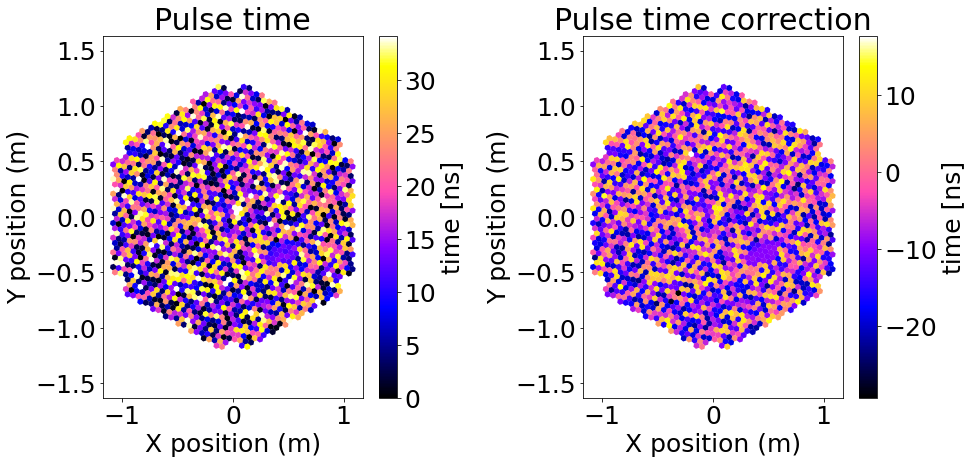

In [ ]:
input_file_1 = "/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01627.0000.fits.fz"

reader = LSTEventSource(input_url=input_file_1, max_events=15)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": None, # For run with baseline correction online
        "offset":  400,
        "tel_id": 1,
        "r1_sample_start":3,
        "r1_sample_end":39
    }
})
tel_id = 1

lst_r0 = LSTR0Corrections(config=config_corr)

extractor = LocalPeakWindowSum(window_width=11, window_shift=4, subarray=reader.subarray)
gain = 0
geom = CameraGeometry.from_name("LSTCam", 2)
pulse_corr = PulseTimeCorrection(calib_file_path='time_calib_run1625.h5')

for i, ev in enumerate(reader):
    lst_r0.calibrate(ev)                       # Cut to see some signal from cosmic events  
    if ev.r0.tel[tel_id].trigger_type == 1 and np.sum(ev.r1.tel[tel_id].waveform[gain, :, :]>600) > 10:
        
        no_gain_selection = np.zeros((2,1855), dtype=np.int8)
        charge, pulse_time = extractor(ev.r1.tel[tel_id].waveform[:, :, :], tel_id, no_gain_selection)
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse_time)
        time_fan = pulse_corr.fan_array[0, :, 0]/2 # mean time from correction curve
        pulse_corr_array = pulse_corr_array - time_fan
           
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        disp1 = CameraDisplay(geom, ax=ax[0])
        disp1.image = pulse_time[gain, :]
        disp1.add_colorbar(ax=ax[0], label="time [ns]")
        disp1.cmap = 'gnuplot2'
        ax[0].set_title("Pulse time")
        
        disp2 = CameraDisplay(geom, ax=ax[1])
        disp2.image = pulse_corr_array[gain, :]
        disp2.add_colorbar(ax=ax[1], label="time [ns]")
        disp2.cmap = 'gnuplot2'
        ax[1].set_title("Pulse time correction")
        plt.tight_layout()        
        plt.show()